In [1]:
import os
import json
import numpy as np
import nibabel as nib
import pandas as pd

from glob import glob

In [2]:
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')

bidsroot = os.path.join(project_dir, 'data_denoised')
deriv_dir = os.path.join(bidsroot, 'derivatives')
fmriprep_dir = os.path.join(deriv_dir, 'denoised_fmriprep-22.1.1')

nilearn_dir = os.path.join(deriv_dir, 'nilearn')
print(nilearn_dir)

mask_dir = os.path.join(project_dir, 'data_bids', 'derivatives', 'nilearn', 'masks')

task_list = ['tonecat']

/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn


In [3]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT27',
               'sub-FLT07', # bad QA 11/14/23
               'sub-FLT10', # MISSING 11/16/23
               #'sub-FLT01', 'sub-FLT16',  
               #'sub-FLT19', 'sub-FLT20',
               #'sub-FLT28', 'sub-FLT30',
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

In [4]:
participants_df

,participant_id,age,sex,group,FFR_id
0,sub-FLT02,21,F,non-Mandarin,1002.0
1,sub-FLT03,25,F,Mandarin,2002.0
2,sub-FLT04,21,F,non-Mandarin,1003.0
3,sub-FLT05,26,M,Mandarin,3010.0
4,sub-FLT06,21,F,non-Mandarin,3001.0
5,sub-FLT08,23,F,Mandarin,2005.0
6,sub-FLT09,30,F,non-Mandarin,3002.0
7,sub-FLT11,20,F,non-Mandarin,1005.0
8,sub-FLT12,20,F,non-Mandarin,3004.0
9,sub-FLT13,23,F,non-Mandarin,3005.0


In [5]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])
sub_dict = {'Mandarin': sub_list_mand, 'non-Mandarin': sub_list_nman}

## define anatomical masks

In [6]:
network_name = 'tian_subcortical_S3' # auditory

if network_name == 'auditory':
    roi_list = [
                'L-IC', 'L-MGN', 'L-HG', 'L-PT',  'L-PP', 'L-STGp', 'L-STGa', 'L-ParsOp', 'L-ParsTri',
                'R-IC', 'R-MGN', 'R-HG', 'R-PT',  'R-PP', 'R-STGp', 'R-STGa', 'R-ParsOp', 'R-ParsTri', 
               ]
elif network_name == 'aud-striatal':
    roi_list = ['L-Caud', 'L-Put', 'L-IC', 'L-MGN',
                'L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 
                'L-ParsOp', 'L-ParsTri',
                'R-Caud', 'R-Put','R-IC', 'R-MGN',
                'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', 
                'R-ParsOp', 'R-ParsTri',
               ]
elif network_name == 'tian_subcortical_S3':
    roi_list = [
                'CAU-DA-lh', 'CAU-VA-lh', 'pCAU-lh', 
                'PUT-DA-lh', 'PUT-DP-lh', 'PUT-VA-lh', 'PUT-VP-lh',
                'aGP-lh', 'pGP-lh', 'NAc-core-lh', 'NAc-shell-lh',
                'CAU-DA-rh', 'CAU-VA-rh', 'pCAU-rh', 
                'PUT-DA-rh', 'PUT-DP-rh', 'PUT-VA-rh', 'PUT-VP-rh',
                'aGP-rh', 'pGP-rh', 'NAc-core-rh', 'NAc-shell-rh', 
               ]

## Define data and labels

In [7]:
def create_labels(stat_maps):
    import os
    from glob import glob
    from numpy.random import shuffle
    from copy import copy
    
    # 16 stimulus decoding
    #conditions_all = [os.path.basename(x)[-31:-18] for x in stat_maps] 
    conditions_all = ['_'.join(os.path.basename(x).split('_')[5:8]) for x in (stat_maps)]
    #print('all events: ', conditions_all[:10])

    # 4-category decoding
    conditions_tone = [os.path.basename(x).split('_')[5] for x in (stat_maps)]

    conditions_talker = [os.path.basename(x).split('_')[6] for x in (stat_maps)]
    
    # shuffled conditions
    conditions_shuffled = copy(conditions_tone)
    shuffle(conditions_shuffled)

    return conditions_tone, conditions_talker, conditions_all, conditions_shuffled

## Decoding

### scikit learn

In [8]:
def mask_fmri(fmri_niimgs, mask_filename, fwhm):
    from nilearn.maskers import NiftiMasker
    masker = NiftiMasker(mask_img=mask_filename, #runs=session_label,
                         smoothing_fwhm=fwhm, standardize=True,
                         #memory="nilearn_cache", memory_level=1
                        )
    fmri_masked = masker.fit_transform(fmri_niimgs)
    return fmri_masked, masker

In [9]:
def sub_region_svc(sub_id, mask_fpath, stat_maps, cv, fwhm=1.5, space_label='T1w'):
    from sklearn.svm import SVC
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import permutation_test_score

    #print(sub_id)
    #print(os.path.basename(mask_fpath))
          
    conditions_tone, conditions_talker, conditions_all, conditions_shuffled = create_labels(stat_maps)

    # extract beta values from stat maps for given region of interest
    fmri_masked, masker = mask_fmri(stat_maps, mask_fpath, fwhm_sub)

    svc = SVC()

    tone_cv_scores = cross_val_score(svc, fmri_masked, conditions_tone, cv=cv)
    print("Tone SVC accuracy: {:.3f} with a standard deviation of {:.2f}".format(tone_cv_scores.mean(),tone_cv_scores.std()))

    talker_cv_scores = cross_val_score(svc, fmri_masked, conditions_talker, cv=cv)
    print("Talker SVC accuracy: {:.3f} with a standard deviation of {:.2f}".format(talker_cv_scores.mean(),talker_cv_scores.std()))

    null_cv_scores = permutation_test_score(svc, fmri_masked, conditions_tone, cv=cv, )[1]
    print("Permutation test score: {:.3f} with a standard deviation of {:.2f}".format(null_cv_scores.mean(),null_cv_scores.std()))
    
    #plot_confusion_matrix(fmri_masked, conditions_tone, mask_descrip, sub_id)
    #plot_confusion_matrix(fmri_masked, conditions_talker, mask_descrip, sub_id)
    
    return fmri_masked, tone_cv_scores, talker_cv_scores, null_cv_scores

#### Confusion matrix

In [10]:
def plot_confusion_matrix(X, y, mask_descrip, sub_id):
    import numpy as np
    import matplotlib.pyplot as plt

    from sklearn import svm, datasets
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import ConfusionMatrixDisplay

    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        random_state=0, stratify=y)

    # Run classifier, using a model that is too regularized (C too low) to see
    # the impact on the results
    classifier = svm.SVC(kernel="linear", ).fit(X_train, y_train)

    np.set_printoptions(precision=2)

    sub_title = 'sub-%s mask-%s'%(sub_id, mask_descrip)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", "true"),]
    #for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            #display_labels=class_names,
            cmap=plt.cm.Blues,
            #normalize='true', 
            )
    disp.ax_.set_title(sub_title)

    #print(title)
    #print(disp.confusion_matrix)

    #plt.show()
    
    return disp.confusion_matrix

#### Confusion matrices across regions

In [11]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

fwhm_sub = 0.00
space_label = 'MNI152NLin2009cAsym'

model_desc = 'stimulus_per_run_LSS'
maptype = 'tstat'
split_design = 'random'

sub_list_temp = participants_df.participant_id.to_list()
sub_list = [x.split('-')[1] for x in sub_list_temp]

print(roi_list)
num_rois = len(roi_list)

['CAU-DA-lh', 'CAU-VA-lh', 'pCAU-lh', 'PUT-DA-lh', 'PUT-DP-lh', 'PUT-VA-lh', 'PUT-VP-lh', 'aGP-lh', 'pGP-lh', 'NAc-core-lh', 'NAc-shell-lh', 'CAU-DA-rh', 'CAU-VA-rh', 'pCAU-rh', 'PUT-DA-rh', 'PUT-DP-rh', 'PUT-VA-rh', 'PUT-VP-rh', 'aGP-rh', 'pGP-rh', 'NAc-core-rh', 'NAc-shell-rh']


In [12]:
# options: 'sound', 'resp', 'fb' (only available for non-Mandarin speakers)
contrast_label = 'sound'

In [13]:
out_dir = os.path.join(
                       bidsroot, 'derivatives', 'nilearn', 
                       #'level-1_fwhm-%.02f'%fwhm_sub,
                       'level-1_den_mvpc-roi',
                       network_name)
os.makedirs(out_dir, exist_ok=True)

In [14]:
print(out_dir)

/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_den_mvpc-roi/tian_subcortical_S3


In [15]:
ls $out_dir

In [ ]:
mand_conf_mat = []
nman_conf_mat = []
for group_id, vals in sub_dict.items(): # ['FLT07'] # sub_list
    for sub_id in vals:
        print(f'grp-{group_id} {sub_id}')
        sub_conf_mat = []

        fig, axs = plt.subplots(nrows=2, ncols=round(num_rois/2), 
                                figsize=(num_rois,6), dpi=200)

        nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                           'level-1_fwhm-%.02f'%fwhm_sub, 
                                           '%s_space-%s'%(sub_id, space_label))

        # run-specific stimulus beta maps
        stat_maps = sorted(glob(nilearn_sub_dir+f'/{model_desc}/run*/*{contrast_label}*map-{maptype}.nii.gz')) 
        print('# of stat maps: ', len(stat_maps))    
        #print(stat_maps)

        # generate condition labels based on filenames
        conditions_tone, conditions_talker, conditions_all, conditions_shuffled = create_labels(stat_maps)

        for mx, mask_descrip in enumerate(roi_list):
            # define the mask for the region of interest
            print(mask_descrip)
            masks_dir = os.path.join(mask_dir, '%s'%sub_id, 'space-%s'%space_label)
            mask_fpath = glob(masks_dir + '/masks-*/' + '%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))[0]

            fmri_masked, masker = mask_fmri(stat_maps, mask_fpath, fwhm_sub)

            # Split the data into a training set and a test set
            x, y = fmri_masked, conditions_tone
            if split_design == 'random':

                X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                                    test_size=0.25,
                                                                    random_state=0, 
                                                                    stratify=y)

            elif split_design == 'talker-sex':
                # split into male and female talker stimuli
                stim_m_indices = [i for i, s in enumerate(conditions_all) if any(xs in s for xs in ['aN', 'bN'])]
                stim_f_indices = [i for i, s in enumerate(conditions_all) if any(xs in s for xs in ['hN', 'iN'])]

                # train male, test female
                X_train = x[stim_m_indices]
                y_train = [y[i] for i in stim_m_indices]
                X_test = x[stim_f_indices]
                y_test = [y[i] for i in stim_f_indices]

            # Run classifier
            clf = svm.SVC(decision_function_shape='ovo').fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            clf_acc = accuracy_score(y_test, y_pred)
            print(f'accuracy: {clf_acc:.04f}')

            ax = plt.subplot(2, num_rois/2, mx + 1)
            ax.set_title(f'{mask_descrip} \n acc = {clf_acc:.04f}')
            cm = confusion_matrix(y_test, y_pred, normalize='true',)
            csv_out_fpath = os.path.join(out_dir, f'{sub_id}_mask-{mask_descrip}_contrast-{contrast_label}_split-{split_design}_confusion_matrix.csv')
            np.savetxt(csv_out_fpath, cm)
            
            cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                                                 ax=ax, 
                                                                  colorbar=False, 
                                                                  im_kw={'cmap':'Blues'},
                                                                  display_labels=['T1', 'T2', 'T3', 'T4'],
                                                                  include_values=False)
            

            sub_conf_mat.append(cm)
        # update figure suptitle
        fig.suptitle(f'group-{group_id} {sub_id}')
        # better spacing
        fig.tight_layout()

        fig_fname = f'grp-{group_id}_{sub_id}_auditory_label-tone_split-{split_design}_confusion_matrices.png'
        fig.savefig(os.path.join(out_dir, fig_fname))

        # append to group list
        if sub_id in sub_list_mand:
            mand_conf_mat.append(sub_conf_mat)
        elif sub_id in sub_list_nman:
            nman_conf_mat.append(sub_conf_mat)

grp-Mandarin sub-FLT03
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0833
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
grp-Mandarin sub-FLT05
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4583
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0833
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4583
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
grp-Mandarin sub-FLT08
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
grp-Mandarin sub-FLT15
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
grp-Mandarin sub-FLT17
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
grp-Mandarin sub-FLT18
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0417
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0417
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
grp-Mandarin sub-FLT19
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
grp-Mandarin sub-FLT21
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0417
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
grp-Mandarin sub-FLT22
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0833
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0833
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
grp-Mandarin sub-FLT23
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
grp-Mandarin sub-FLT24
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0833
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0833
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
grp-Mandarin sub-FLT26
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
grp-non-Mandarin sub-FLT02
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0417
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
grp-non-Mandarin sub-FLT04
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
grp-non-Mandarin sub-FLT06
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
grp-non-Mandarin sub-FLT09
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4583
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4583
grp-non-Mandarin sub-FLT11
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
grp-non-Mandarin sub-FLT12
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0417
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4583
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
grp-non-Mandarin sub-FLT13
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
grp-non-Mandarin sub-FLT14
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4583
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0833
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
grp-non-Mandarin sub-FLT20


/scratch/slurm-2442600/ipykernel_150630/175712125.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=2, ncols=round(num_rois/2),


# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1250
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
grp-non-Mandarin sub-FLT25
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4583
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4583
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
grp-non-Mandarin sub-FLT28
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0833
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.1667
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
grp-non-Mandarin sub-FLT30
# of stat maps:  96
CAU-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2917
CAU-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
pCAU-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-DP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VA-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4583
PUT-VP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
aGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
pGP-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
NAc-core-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
NAc-shell-lh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
CAU-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
CAU-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
pCAU-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2500
PUT-DA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-DP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
PUT-VA-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
PUT-VP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3333
aGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.3750
pGP-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.4167
NAc-core-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.2083
NAc-shell-rh


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0.0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


accuracy: 0.0833


### Group mean matrices

In [ ]:
'''
mand_mean_cm = np.mean(mand_conf_mat, axis=0)
nman_mean_cm = np.mean(nman_conf_mat, axis=0)
'''

In [28]:
out_dir = os.path.join(nilearn_dir, 
                       f'level-1_fwhm-{fwhm_sub:.02f}', 
                       'level-1_den_mvpc-roi',
                       network_name,
                       f'contrast-{contrast_label}')

#### Read in pre-generated single-subject, single-ROI confusion matrices

In [30]:
mand_acc_dict = dict()
mand_cm_dict = dict()
for rx, roi in enumerate(roi_list):
    mand_acc = []
    subroi_list = []
    for sx, sub_id in enumerate(sub_list_mand):
        fpath = os.path.join(out_dir, #'level-1_mvpc-roi',
                             #f'{sub_id}_mask-{roi}_label-tone_split-{split_design}_confusion_matrix.csv',
                             f'{sub_id}_mask-{roi}_contrast-{contrast_label}_label-assigned_confusion_matrix.csv',
                            )
        sr_data = np.genfromtxt(fpath)
        subroi_list.append(sr_data)
        
        sub_acc = np.diag(sr_data).mean()
        mand_acc.append(sub_acc)
    mand_subroi = np.array(subroi_list)
    mean_roi = mand_subroi.mean(axis=0)
    mand_cm_dict[roi] = mean_roi
    mand_acc_dict[roi] = mand_acc

nman_acc_dict = dict()
nman_cm_dict = dict()
for rx, roi in enumerate(roi_list):
    nman_acc = []
    subroi_list = []
    for sx, sub_id in enumerate(sub_list_nman):
        fpath = os.path.join(out_dir, #'level-1_mvpc-roi',
                             #f'{sub_id}_mask-{roi}_label-tone_split-{split_design}_confusion_matrix.csv',
                             f'{sub_id}_mask-{roi}_contrast-{contrast_label}_label-assigned_confusion_matrix.csv',
                            )
        sr_data = np.genfromtxt(fpath)
        subroi_list.append(sr_data)
        
        sub_acc = np.diag(sr_data).mean()
        nman_acc.append(sub_acc)
    mand_subroi = np.array(subroi_list)
    mean_roi = mand_subroi.mean(axis=0)
    nman_cm_dict[roi] = mean_roi
    nman_acc_dict[roi] = nman_acc

In [19]:
'''
# OLDER VERSION 
mand_acc_dict = dict()
mand_cm_dict = dict()
for rx, roi in enumerate(roi_list):
    mand_acc = []
    subroi_list = []
    for sx, sub_id in enumerate(sub_list_mand):
        fpath = os.path.join(out_dir, #'level-1_mvpc-roi',
                             f'{sub_id}_mask-{roi}_label-tone_split-{split_design}_confusion_matrix.csv')
        sr_data = np.genfromtxt(fpath)
        subroi_list.append(sr_data)
        
        sub_acc = np.diag(sr_data).mean()
        mand_acc.append(sub_acc)
    mand_subroi = np.array(subroi_list)
    mean_roi = mand_subroi.mean(axis=0)
    mand_cm_dict[roi] = mean_roi
    mand_acc_dict[roi] = mand_acc

nman_acc_dict = dict()
nman_cm_dict = dict()
for rx, roi in enumerate(roi_list):
    nman_acc = []
    subroi_list = []
    for sx, sub_id in enumerate(sub_list_nman):
        fpath = os.path.join(out_dir, #'level-1_mvpc-roi',
                             f'{sub_id}_mask-{roi}_label-tone_split-{split_design}_confusion_matrix.csv')
        sr_data = np.genfromtxt(fpath)
        subroi_list.append(sr_data)
        
        sub_acc = np.diag(sr_data).mean()
        nman_acc.append(sub_acc)
    mand_subroi = np.array(subroi_list)
    mean_roi = mand_subroi.mean(axis=0)
    nman_cm_dict[roi] = mean_roi
    nman_acc_dict[roi] = nman_acc

from scipy import stats

mean_accs = []
p_vals = []
t_stats = []
print(f'Native Mandarin mean SVC accuracy')
for rx, roi in enumerate(roi_list):
    mand_roi_acc = np.array(mand_acc_dict[roi])
    mean_acc = mand_roi_acc.mean()
    
    ttest_res = stats.ttest_1samp(mand_roi_acc, popmean=0.25)
    print(f'mean SVC accuracy = {mean_acc:.04f} p = {ttest_res.pvalue:.04f} t = {ttest_res.statistic:.02f} region = {roi}')
    
    mean_accs.append(mean_acc)
    p_vals.append(ttest_res.pvalue)
    t_stats.append(ttest_res.statistic)

p_vals_adj = stats.false_discovery_control(p_vals)
for rx, roi in enumerate(roi_list):
    print(f'mean SVC accuracy = {mean_accs[rx]:.04f} t = {t_stats[rx]:.02f} FDR-corrected p = {p_vals_adj[rx]:.04f} region = {roi}')

mean_accs = []
p_vals = []
t_stats = []
print(f'Non-Mandarin mean SVC accuracy')
for rx, roi in enumerate(roi_list):
    nman_roi_acc = np.array(nman_acc_dict[roi])
    mean_acc = nman_roi_acc.mean()
    
    ttest_res = stats.ttest_1samp(nman_roi_acc, popmean=0.25)
    print(f'mean SVC accuracy = {mean_acc:.04f} p = {ttest_res.pvalue:.04f} t = {ttest_res.statistic:.02f} region = {roi}')
    
    mean_accs.append(mean_acc)
    p_vals.append(ttest_res.pvalue)
    t_stats.append(ttest_res.statistic)

p_vals_adj = stats.false_discovery_control(p_vals)
for rx, roi in enumerate(roi_list):
    print(f'mean SVC accuracy = {mean_accs[rx]:.04f} t = {t_stats[rx]:.02f} FDR-corrected p = {p_vals_adj[rx]:.04f} region = {roi}')
'''

FileNotFoundError: /bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_den_mvpc-roi/tian_subcortical_S3/sub-FLT03_mask-CAU-DA-lh_label-tone_split-random_confusion_matrix.csv not found.

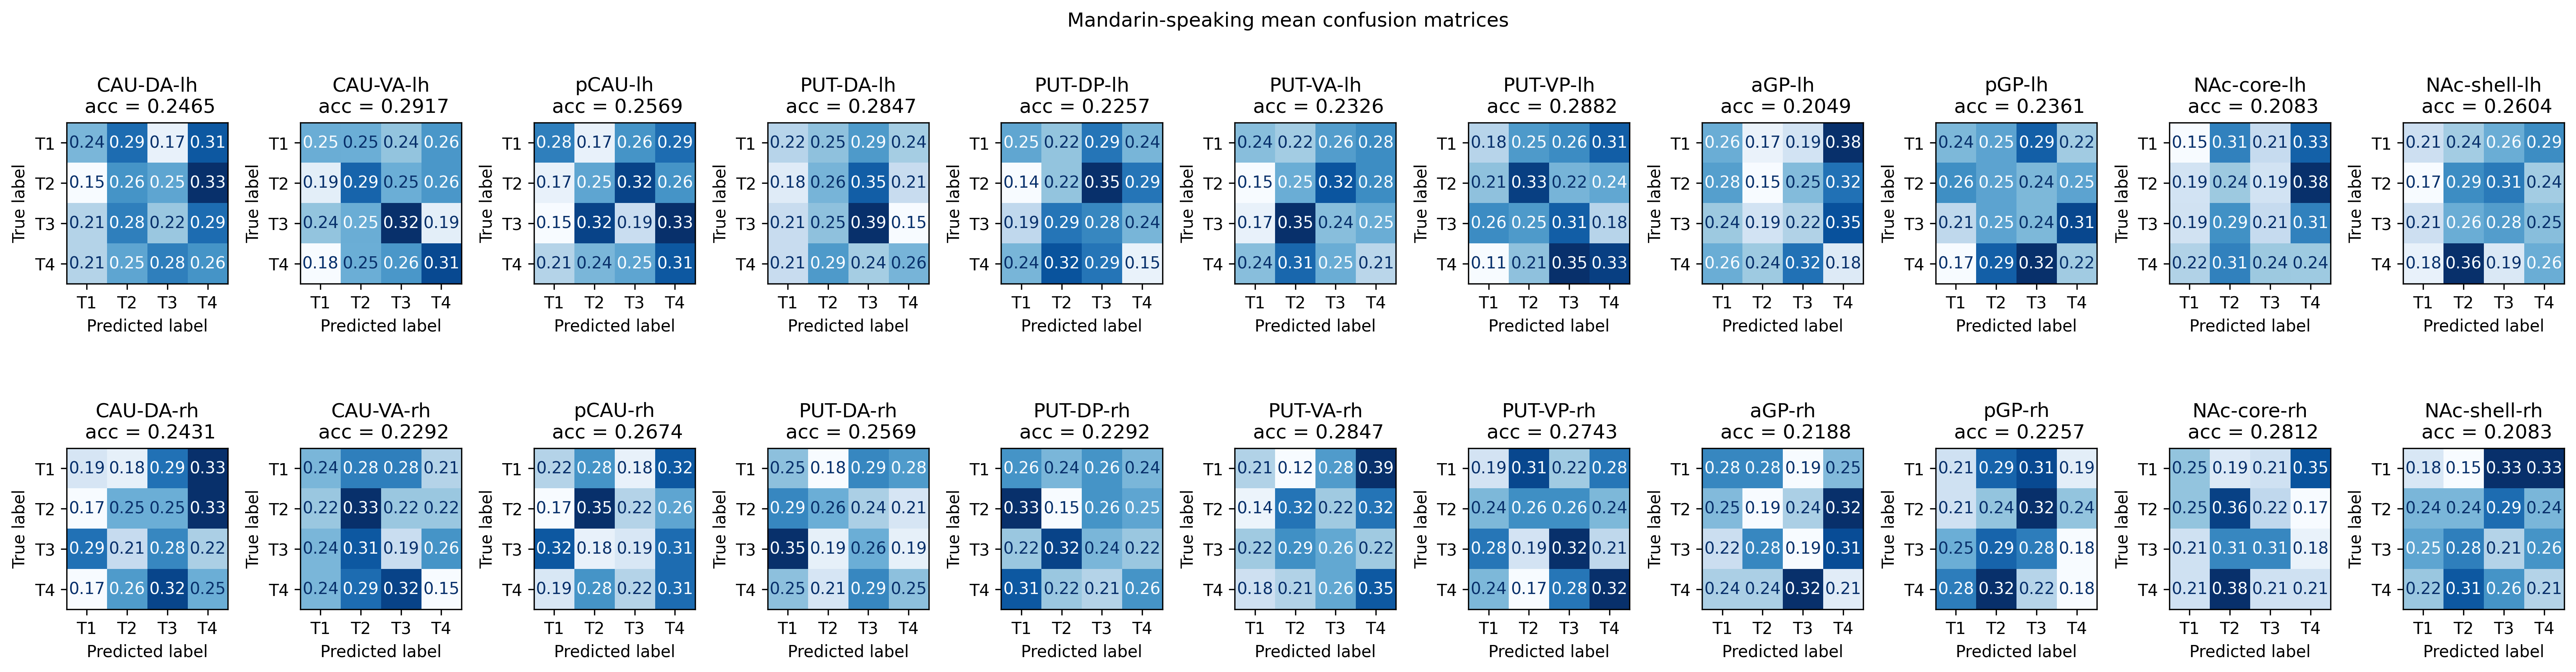

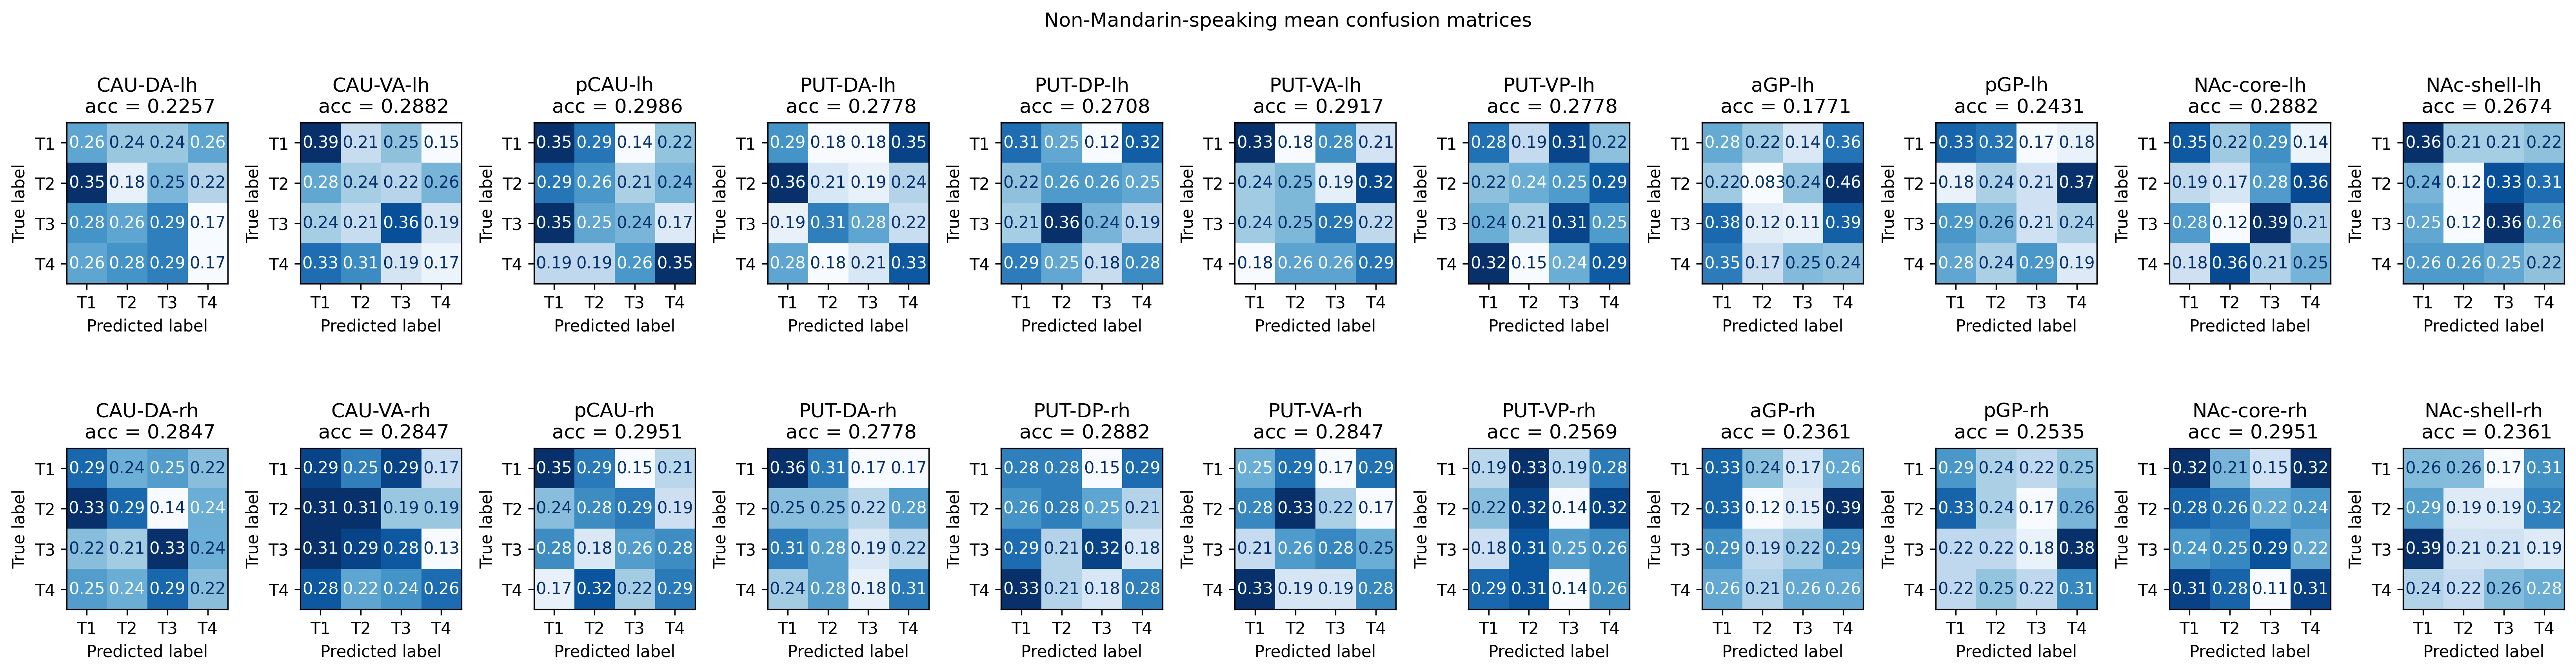

In [31]:
# Mandarin-speaking participants
fig, axs = plt.subplots(nrows=2, ncols=round(num_rois/2), figsize=(num_rois,6), dpi=300)
fig.suptitle('Mandarin-speaking mean confusion matrices')

for mx, mask_descrip in enumerate(roi_list):
    ax = plt.subplot(2, num_rois/2, mx + 1)
    ConfusionMatrixDisplay(mand_cm_dict[mask_descrip],).plot(ax=ax, colorbar=False, 
                                                   im_kw={'cmap':'Blues', },
                                                   include_values=True)
    roi_mean = np.diag(mand_cm_dict[mask_descrip]).mean()
    ax.set_title(f'{mask_descrip}\n acc = {roi_mean:.04}')
    ax.set_xticklabels(['T1','T2','T3','T4'])
    ax.set_yticklabels(['T1','T2','T3','T4'])
# better spacing
fig.tight_layout()
fig.savefig('level-2_den_mvpc-roi/' + f'group-Mand_contrast-{contrast_label}_{network_name}_split-{split_design}_label-tone_incl-vals_confusion_matrices.png')

# Non-Mandarin-speaking participants
fig2, axs = plt.subplots(nrows=2, ncols=round(num_rois/2), figsize=(num_rois,6), dpi=300)
fig2.suptitle('Non-Mandarin-speaking mean confusion matrices')

for mx, mask_descrip in enumerate(roi_list):
    ax = plt.subplot(2, num_rois/2, mx + 1)
    ConfusionMatrixDisplay(nman_cm_dict[mask_descrip],).plot(ax=ax, colorbar=False, 
                                                   im_kw={'cmap':'Blues', },
                                                   include_values=True)
    roi_mean = np.diag(nman_cm_dict[mask_descrip]).mean()
    ax.set_title(f'{mask_descrip}\n acc = {roi_mean:.04}')
    ax.set_xticklabels(['T1','T2','T3','T4'])
    ax.set_yticklabels(['T1','T2','T3','T4'])
# better spacing
fig2.tight_layout()
fig2.savefig('level-2_den_mvpc-roi/' + f'group-NMan_contrast-{contrast_label}_{network_name}_split-{split_design}_label-tone_incl-vals_confusion_matrices.png')

### Group-specific stats

In [32]:
from scipy import stats

mean_accs = []
p_vals = []
t_stats = []
print(f'Native Mandarin mean SVC accuracy')
for rx, roi in enumerate(roi_list):
    mand_roi_acc = np.array(mand_acc_dict[roi])
    mean_acc = mand_roi_acc.mean()
    
    ttest_res = stats.ttest_1samp(mand_roi_acc, popmean=0.25)
    print(f'mean SVC accuracy = {mean_acc:.04f} p = {ttest_res.pvalue:.04f} t = {ttest_res.statistic:.02f} region = {roi}')
    
    mean_accs.append(mean_acc)
    p_vals.append(ttest_res.pvalue)
    t_stats.append(ttest_res.statistic)

p_vals_adj = stats.false_discovery_control(p_vals)
for rx, roi in enumerate(roi_list):
    print(f'mean SVC accuracy = {mean_accs[rx]:.04f} t = {t_stats[rx]:.02f} FDR-corrected p = {p_vals_adj[rx]:.04f} region = {roi}')

mean_accs = []
p_vals = []
t_stats = []
print(f'Non-Mandarin mean SVC accuracy')
for rx, roi in enumerate(roi_list):
    nman_roi_acc = np.array(nman_acc_dict[roi])
    mean_acc = nman_roi_acc.mean()
    
    ttest_res = stats.ttest_1samp(nman_roi_acc, popmean=0.25)
    print(f'mean SVC accuracy = {mean_acc:.04f} p = {ttest_res.pvalue:.04f} t = {ttest_res.statistic:.02f} region = {roi}')
    
    mean_accs.append(mean_acc)
    p_vals.append(ttest_res.pvalue)
    t_stats.append(ttest_res.statistic)

p_vals_adj = stats.false_discovery_control(p_vals)
for rx, roi in enumerate(roi_list):
    print(f'mean SVC accuracy = {mean_accs[rx]:.04f} t = {t_stats[rx]:.02f} FDR-corrected p = {p_vals_adj[rx]:.04f} region = {roi}')

Native Mandarin mean SVC accuracy
mean SVC accuracy = 0.2465 p = 0.8957 t = -0.13 region = CAU-DA-lh
mean SVC accuracy = 0.2917 p = 0.0671 t = 2.03 region = CAU-VA-lh
mean SVC accuracy = 0.2569 p = 0.8468 t = 0.20 region = pCAU-lh
mean SVC accuracy = 0.2847 p = 0.1272 t = 1.65 region = PUT-DA-lh
mean SVC accuracy = 0.2257 p = 0.1891 t = -1.40 region = PUT-DP-lh
mean SVC accuracy = 0.2326 p = 0.5521 t = -0.61 region = PUT-VA-lh
mean SVC accuracy = 0.2882 p = 0.1524 t = 1.54 region = PUT-VP-lh
mean SVC accuracy = 0.2049 p = 0.0353 t = -2.40 region = aGP-lh
mean SVC accuracy = 0.2361 p = 0.3049 t = -1.08 region = pGP-lh
mean SVC accuracy = 0.2083 p = 0.1970 t = -1.37 region = NAc-core-lh
mean SVC accuracy = 0.2604 p = 0.5549 t = 0.61 region = NAc-shell-lh
mean SVC accuracy = 0.2431 p = 0.7668 t = -0.30 region = CAU-DA-rh
mean SVC accuracy = 0.2292 p = 0.2143 t = -1.32 region = CAU-VA-rh
mean SVC accuracy = 0.2674 p = 0.5161 t = 0.67 region = pCAU-rh
mean SVC accuracy = 0.2569 p = 0.7545 t

### Combine all subjects

In [ ]:
all_cm_dict = dict()
all_acc_dict = dict()
for rx, roi in enumerate(roi_list):
    all_acc = []
    subroi_list = []
    for sx, sub_id in enumerate(sub_list):
        fpath = os.path.join(out_dir, #'level-1_mvpc-roi',
                             f'sub-{sub_id}_mask-{roi}_label-tone_split-{split_design}_confusion_matrix.csv')
        sr_data = np.genfromtxt(fpath)
        subroi_list.append(sr_data)
        
        sub_acc = np.diag(sr_data).mean()
        all_acc.append(sub_acc)
    all_subroi = np.array(subroi_list)
    mand_subroi = np.array(subroi_list)
    mean_roi = all_subroi.mean(axis=0)
    all_cm_dict[roi] = mean_roi
    all_acc_dict[roi] = all_acc

In [ ]:
from scipy import stats

mean_accs = []
p_vals = []
t_stats = []
print(f'All participants mean SVC accuracy')
for rx, roi in enumerate(roi_list):
    all_roi_acc = np.array(all_acc_dict[roi])
    mean_acc = all_roi_acc.mean()
    
    ttest_res = stats.ttest_1samp(all_roi_acc, popmean=0.25)
    print(f'mean SVC accuracy = {mean_acc:.04f} p = {ttest_res.pvalue:.04f} t = {ttest_res.statistic:.02f} region = {roi}')
    
    mean_accs.append(mean_acc)
    p_vals.append(ttest_res.pvalue)
    t_stats.append(ttest_res.statistic)

# FDR-corrected stats
p_vals_adj = stats.false_discovery_control(p_vals)
print('\nFDR-adjusted statistics')
for rx, roi in enumerate(roi_list):
    if p_vals_adj[rx] < 0.01:
        ast = '**'
    elif p_vals_adj[rx] < 0.05:
        ast = ' *'
    else:
        ast = '  '
    print(f'{ast}t = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.04f} region = {roi}')


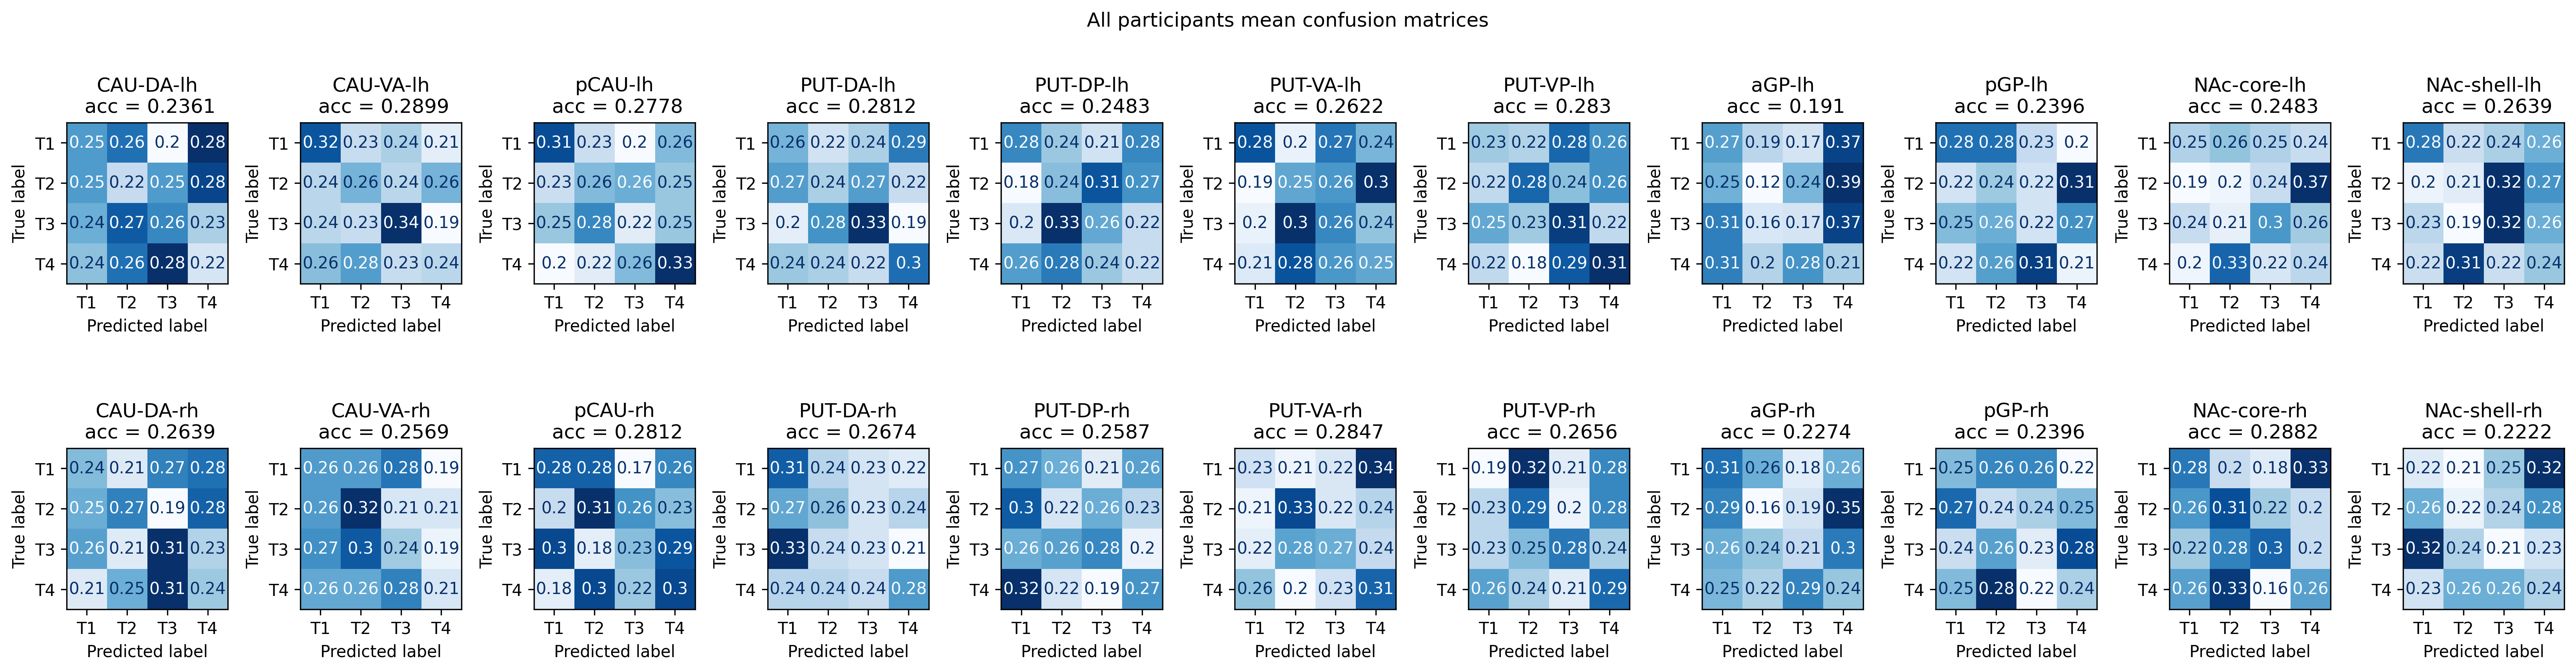

In [29]:

# All participants
fig2, axs = plt.subplots(nrows=2, ncols=round(num_rois/2), figsize=(num_rois,6), dpi=300)
fig2.suptitle('All participants mean confusion matrices')

for mx, mask_descrip in enumerate(roi_list):
    ax = plt.subplot(2, num_rois/2, mx + 1)
    ConfusionMatrixDisplay(all_cm_dict[mask_descrip],).plot(ax=ax, colorbar=False, 
                                                   im_kw={'cmap':'Blues', },
                                                   include_values=True)
    roi_mean = np.diag(all_cm_dict[mask_descrip]).mean()
    ax.set_title(f'{mask_descrip}\n acc = {roi_mean:.04}')
    ax.set_xticklabels(['T1','T2','T3','T4'])
    ax.set_yticklabels(['T1','T2','T3','T4'])
# better spacing
fig2.tight_layout()
fig2.savefig('level-2_den_mvpc-roi/' + f'group-all_{network_name}_split-{split_design}_label-tone_incl-vals_confusion_matrices.png')

### Compare with behavior

In [109]:
from scipy.stats import spearmanr

In [111]:
for sub_id in sub_list:
    print(sub_id)
    behav_cm = np.genfromtxt('behav_confusion_matrices/sub-{}_behav_confusion_matrix.csv'.format(sub_id))    
    behav_off_diag = behav_cm[np.where(~np.eye(behav_cm.shape[0],dtype=bool))]
    #print(behav_off_diag)
    for mx, mask_descrip in enumerate(roi_list):
        mask_cm = np.genfromtxt('striatal_confusion_matrices/sub-{}_mask-{}_label-{}_confusion_matrix.csv'.format(sub_id, mask_descrip, 'tone'))
        mask_off_diag = mask_cm[np.where(~np.eye(mask_cm.shape[0],dtype=bool))]
        #print(mask_off_diag)
        
        r, p = spearmanr(behav_off_diag, mask_off_diag)
        print('{} r = {:.03f} p = {:.03f}'.format(mask_descrip, r, p))

FLT01
L-Caud r = -0.091 p = 0.779
L-Put r = 0.674 p = 0.016
R-Caud r = 0.522 p = 0.082
R-Put r = 1.000 p = 0.000
FLT03
L-Caud r = 0.113 p = 0.727
L-Put r = -0.199 p = 0.535
R-Caud r = 0.739 p = 0.006
R-Put r = 0.739 p = 0.006
FLT05
L-Caud r = 0.180 p = 0.575
L-Put r = 0.158 p = 0.624
R-Caud r = -0.199 p = 0.535
R-Put r = -0.135 p = 0.676
FLT07
L-Caud r = nan p = nan
L-Put r = nan p = nan
R-Caud r = nan p = nan
R-Put r = nan p = nan
FLT08
L-Caud r = nan p = nan
L-Put r = nan p = nan
R-Caud r = nan p = nan
R-Put r = nan p = nan
FLT10
L-Caud r = -0.255 p = 0.424
L-Put r = 0.604 p = 0.037
R-Caud r = -0.174 p = 0.588
R-Put r = -0.134 p = 0.677
FLT02
L-Caud r = 0.024 p = 0.940
L-Put r = 0.297 p = 0.349
R-Caud r = 0.381 p = 0.222
R-Put r = 0.087 p = 0.787
FLT04
L-Caud r = 0.787 p = 0.002
L-Put r = 0.547 p = 0.066
R-Caud r = 0.795 p = 0.002
R-Put r = 0.709 p = 0.010
FLT06
L-Caud r = 0.073 p = 0.822
L-Put r = 0.032 p = 0.923
R-Caud r = 0.198 p = 0.538
R-Put r = 0.273 p = 0.390
FLT09
L-Caud r = 

'1.6.2'

### Run pipeline

In [26]:
from sklearn.model_selection import KFold, StratifiedKFold

fwhm_sub = 0 # 1.5
space_label = 'MNI152NLin2009cAsym' #'T1w' 

cv = StratifiedKFold(n_splits=4)

In [27]:
#roi_list = list(roi_dict.keys())
print(roi_list)

['L-CN', 'L-SOC', 'L-IC', 'L-MGN', 'R-CN', 'R-SOC', 'R-IC', 'R-MGN']


In [38]:
nilearn_sub_dir

'/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT01_space-MNI152NLin2009cAsym/trial_models'

In [ ]:
cv_list_tone = []
cv_list_talker = []
cv_list_null = []
for sub_id in sub_list:
    print(sub_id)
    sub_tone = []
    sub_talker = []
    sub_null = []
    
    for mask_descrip in roi_list:
        # define the mask for the region of interest
        print(mask_descrip)
        masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 'masks-subcort-aud', ) # 'masks-aparc'
        mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
        #mask_img = nib.load(mask_fpath)

        '''
        t1w_fpath = os.path.join(fmriprep_dir, 'sub-%s'%sub_id, 'anat', 
                                 'sub-%s_desc-preproc_T1w.nii.gz'%sub_id)
        print('T1w file path: ', t1w_fpath)
        brainmask_fpath = os.path.join(fmriprep_dir, 'sub-%s'%sub_id, 'anat', 
                                 'sub-%s_desc-brain_mask.nii.gz'%sub_id)
        print('brain mask file path: ', brainmask_fpath)
        '''
        nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                       'level-1_fwhm-%.02f'%fwhm_sub, 
                                       'sub-%s_space-%s'%(sub_id, space_label),
                                       'trial_models')

        stat_maps = sorted(glob(nilearn_sub_dir+'/run*/*di*nii.gz')) # run-specific stimulus beta maps
        #stat_maps = sorted(glob(nilearn_sub_dir+'/trial_models'+'/run*/*di*trial*nii.gz')) # run-specific trial beta maps
        #stat_maps = sorted(glob(nilearn_sub_dir+'/run-all/*di*beta.nii.gz')) # run-all
        print('# of stat maps: ', len(stat_maps))    

        fmri_masked, tone_cv_scores, \
            talker_cv_scores, null_cv_scores = sub_region_svc(sub_id, mask_fpath, stat_maps, cv, 
                                                              fwhm=fwhm_sub, space_label=space_label)
        sub_tone.append(tone_cv_scores)
        sub_talker.append(talker_cv_scores)
        sub_null.append(null_cv_scores)
    
    # append subject cv scores to overall list
    cv_list_tone.append(sub_tone)
    cv_list_talker.append(sub_talker)
    cv_list_null.append(sub_null)

FLT01
L-CN
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.344 with a standard deviation of 0.10
Talker SVC accuracy: 0.266 with a standard deviation of 0.03
Permutation test score: 0.244 with a standard deviation of 0.06
L-SOC
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.281 with a standard deviation of 0.03
Talker SVC accuracy: 0.312 with a standard deviation of 0.04
Permutation test score: 0.245 with a standard deviation of 0.06
L-IC
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.156 with a standard deviation of 0.09
Talker SVC accuracy: 0.250 with a standard deviation of 0.04
Permutation test score: 0.228 with a standard deviation of 0.06
L-MGN
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.172 with a standard deviation of 0.05
Talker SVC accuracy: 0.266 with a standard deviation of 0.07
Permutation test score: 0.229 with a standard deviation of 0.06
R-CN
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.219 with a standard deviation of 0.11
Talker SVC accuracy: 0.203 with a standard deviation of 0.08
Permutation test score: 0.248 with a standard deviation of 0.06
R-SOC
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.359 with a standard deviation of 0.16
Talker SVC accuracy: 0.234 with a standard deviation of 0.09
Permutation test score: 0.240 with a standard deviation of 0.07
R-IC
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.328 with a standard deviation of 0.15
Talker SVC accuracy: 0.188 with a standard deviation of 0.08
Permutation test score: 0.237 with a standard deviation of 0.06
R-MGN
# of stat maps:  64


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.344 with a standard deviation of 0.13
Talker SVC accuracy: 0.266 with a standard deviation of 0.05
Permutation test score: 0.234 with a standard deviation of 0.05
FLT03
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.08
Talker SVC accuracy: 0.240 with a standard deviation of 0.02
Permutation test score: 0.244 with a standard deviation of 0.04
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.281 with a standard deviation of 0.07
Talker SVC accuracy: 0.281 with a standard deviation of 0.03
Permutation test score: 0.246 with a standard deviation of 0.06
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.05
Talker SVC accuracy: 0.187 with a standard deviation of 0.06
Permutation test score: 0.220 with a standard deviation of 0.05
L-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.344 with a standard deviation of 0.15
Talker SVC accuracy: 0.323 with a standard deviation of 0.09
Permutation test score: 0.212 with a standard deviation of 0.05
R-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.458 with a standard deviation of 0.10
Talker SVC accuracy: 0.219 with a standard deviation of 0.07
Permutation test score: 0.232 with a standard deviation of 0.05
R-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.198 with a standard deviation of 0.07
Talker SVC accuracy: 0.229 with a standard deviation of 0.04
Permutation test score: 0.233 with a standard deviation of 0.05
R-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.292 with a standard deviation of 0.18
Talker SVC accuracy: 0.260 with a standard deviation of 0.05
Permutation test score: 0.216 with a standard deviation of 0.05
R-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.302 with a standard deviation of 0.10
Talker SVC accuracy: 0.219 with a standard deviation of 0.07
Permutation test score: 0.230 with a standard deviation of 0.06
FLT05
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.240 with a standard deviation of 0.07
Talker SVC accuracy: 0.250 with a standard deviation of 0.05
Permutation test score: 0.241 with a standard deviation of 0.05
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.250 with a standard deviation of 0.03
Talker SVC accuracy: 0.188 with a standard deviation of 0.05
Permutation test score: 0.239 with a standard deviation of 0.05
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.406 with a standard deviation of 0.09
Talker SVC accuracy: 0.302 with a standard deviation of 0.05
Permutation test score: 0.242 with a standard deviation of 0.05
L-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.417 with a standard deviation of 0.10
Talker SVC accuracy: 0.229 with a standard deviation of 0.07
Permutation test score: 0.217 with a standard deviation of 0.05
R-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.365 with a standard deviation of 0.08
Talker SVC accuracy: 0.281 with a standard deviation of 0.09
Permutation test score: 0.228 with a standard deviation of 0.06
R-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.281 with a standard deviation of 0.11
Talker SVC accuracy: 0.177 with a standard deviation of 0.05
Permutation test score: 0.238 with a standard deviation of 0.05
R-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.02
Talker SVC accuracy: 0.250 with a standard deviation of 0.00
Permutation test score: 0.227 with a standard deviation of 0.05
R-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.240 with a standard deviation of 0.03
Talker SVC accuracy: 0.250 with a standard deviation of 0.08
Permutation test score: 0.235 with a standard deviation of 0.05
FLT07
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.312 with a standard deviation of 0.07
Talker SVC accuracy: 0.229 with a standard deviation of 0.06
Permutation test score: 0.239 with a standard deviation of 0.04
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.323 with a standard deviation of 0.05
Talker SVC accuracy: 0.271 with a standard deviation of 0.05
Permutation test score: 0.245 with a standard deviation of 0.05
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.11
Talker SVC accuracy: 0.271 with a standard deviation of 0.05
Permutation test score: 0.228 with a standard deviation of 0.06
L-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.333 with a standard deviation of 0.15
Talker SVC accuracy: 0.250 with a standard deviation of 0.05
Permutation test score: 0.216 with a standard deviation of 0.05
R-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.313 with a standard deviation of 0.06
Talker SVC accuracy: 0.333 with a standard deviation of 0.06
Permutation test score: 0.233 with a standard deviation of 0.05
R-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.385 with a standard deviation of 0.14
Talker SVC accuracy: 0.208 with a standard deviation of 0.05
Permutation test score: 0.231 with a standard deviation of 0.05
R-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.10
Talker SVC accuracy: 0.354 with a standard deviation of 0.07
Permutation test score: 0.223 with a standard deviation of 0.06
R-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.427 with a standard deviation of 0.11
Talker SVC accuracy: 0.312 with a standard deviation of 0.02
Permutation test score: 0.218 with a standard deviation of 0.05
FLT08
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.385 with a standard deviation of 0.12
Talker SVC accuracy: 0.281 with a standard deviation of 0.03
Permutation test score: 0.238 with a standard deviation of 0.06
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.312 with a standard deviation of 0.06
Talker SVC accuracy: 0.260 with a standard deviation of 0.05
Permutation test score: 0.257 with a standard deviation of 0.05
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.375 with a standard deviation of 0.07
Talker SVC accuracy: 0.229 with a standard deviation of 0.06
Permutation test score: 0.229 with a standard deviation of 0.04
L-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.438 with a standard deviation of 0.06
Talker SVC accuracy: 0.292 with a standard deviation of 0.04
Permutation test score: 0.241 with a standard deviation of 0.05
R-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.219 with a standard deviation of 0.12
Talker SVC accuracy: 0.260 with a standard deviation of 0.05
Permutation test score: 0.241 with a standard deviation of 0.05
R-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.146 with a standard deviation of 0.05
Talker SVC accuracy: 0.302 with a standard deviation of 0.05
Permutation test score: 0.242 with a standard deviation of 0.05
R-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.05
Talker SVC accuracy: 0.260 with a standard deviation of 0.03
Permutation test score: 0.226 with a standard deviation of 0.04
R-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.323 with a standard deviation of 0.14
Talker SVC accuracy: 0.219 with a standard deviation of 0.06
Permutation test score: 0.226 with a standard deviation of 0.05
FLT10
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.281 with a standard deviation of 0.16
Talker SVC accuracy: 0.260 with a standard deviation of 0.05
Permutation test score: 0.227 with a standard deviation of 0.05
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.208 with a standard deviation of 0.05
Talker SVC accuracy: 0.250 with a standard deviation of 0.05
Permutation test score: 0.243 with a standard deviation of 0.05
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.260 with a standard deviation of 0.05
Talker SVC accuracy: 0.188 with a standard deviation of 0.02
Permutation test score: 0.235 with a standard deviation of 0.04
L-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.396 with a standard deviation of 0.06
Talker SVC accuracy: 0.260 with a standard deviation of 0.09
Permutation test score: 0.219 with a standard deviation of 0.04
R-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.198 with a standard deviation of 0.06
Talker SVC accuracy: 0.219 with a standard deviation of 0.03
Permutation test score: 0.240 with a standard deviation of 0.05
R-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.281 with a standard deviation of 0.07
Talker SVC accuracy: 0.302 with a standard deviation of 0.05
Permutation test score: 0.242 with a standard deviation of 0.05
R-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.385 with a standard deviation of 0.10
Talker SVC accuracy: 0.260 with a standard deviation of 0.03
Permutation test score: 0.224 with a standard deviation of 0.05
R-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.271 with a standard deviation of 0.14
Talker SVC accuracy: 0.302 with a standard deviation of 0.05
Permutation test score: 0.249 with a standard deviation of 0.04
FLT02
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.281 with a standard deviation of 0.02
Talker SVC accuracy: 0.198 with a standard deviation of 0.03
Permutation test score: 0.243 with a standard deviation of 0.05
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.354 with a standard deviation of 0.06
Talker SVC accuracy: 0.260 with a standard deviation of 0.06
Permutation test score: 0.235 with a standard deviation of 0.05
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.396 with a standard deviation of 0.10
Talker SVC accuracy: 0.198 with a standard deviation of 0.05
Permutation test score: 0.233 with a standard deviation of 0.05
L-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.323 with a standard deviation of 0.08
Talker SVC accuracy: 0.219 with a standard deviation of 0.02
Permutation test score: 0.228 with a standard deviation of 0.05
R-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.219 with a standard deviation of 0.02
Talker SVC accuracy: 0.219 with a standard deviation of 0.02
Permutation test score: 0.249 with a standard deviation of 0.05
R-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.406 with a standard deviation of 0.09
Talker SVC accuracy: 0.260 with a standard deviation of 0.05
Permutation test score: 0.247 with a standard deviation of 0.05
R-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.323 with a standard deviation of 0.09
Talker SVC accuracy: 0.219 with a standard deviation of 0.07
Permutation test score: 0.234 with a standard deviation of 0.05
R-MGN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.219 with a standard deviation of 0.09
Talker SVC accuracy: 0.229 with a standard deviation of 0.07
Permutation test score: 0.221 with a standard deviation of 0.05
FLT04
L-CN
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.250 with a standard deviation of 0.07
Talker SVC accuracy: 0.302 with a standard deviation of 0.08
Permutation test score: 0.244 with a standard deviation of 0.06
L-SOC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.365 with a standard deviation of 0.05
Talker SVC accuracy: 0.333 with a standard deviation of 0.09
Permutation test score: 0.243 with a standard deviation of 0.05
L-IC
# of stat maps:  96


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/image.py:211: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


Tone SVC accuracy: 0.271 with a standard deviation of 0.06
Talker SVC accuracy: 0.240 with a standard deviation of 0.05
Permutation test score: 0.233 with a standard deviation of 0.06
L-MGN
# of stat maps:  96


In [26]:
'''
np.save('cv_list_tone', cv_list_tone)
np.save('cv_list_talker', cv_list_talker)
np.save('cv_list_null', cv_list_null)
np.save('sub_list', sub_list)
np.save('roi_list', roi_list)
'''

In [28]:
import pandas as pd

In [30]:
pd.DataFrame(data=cv_list_tone)

,0,1,2,3,4,5,6,7,8,9,10,11
0,"[0.25, 0.1875, 0.25, 0.375]","[0.125, 0.1875, 0.25, 0.375]","[0.25, 0.25, 0.25, 0.375]","[0.3125, 0.5, 0.25, 0.375]","[0.3125, 0.375, 0.25, 0.3125]","[0.25, 0.375, 0.1875, 0.5625]","[0.1875, 0.25, 0.25, 0.0]","[0.25, 0.0625, 0.25, 0.3125]","[0.25, 0.1875, 0.4375, 0.1875]","[0.25, 0.375, 0.25, 0.1875]","[0.125, 0.375, 0.0625, 0.125]","[0.25, 0.1875, 0.3125, 0.5]"
1,"[0.4583333333333333, 0.375, 0.5, 0.625]","[0.5, 0.5416666666666666, 0.5, 0.5833333333333...","[0.625, 0.4583333333333333, 0.5416666666666666...","[0.5, 0.4166666666666667, 0.4583333333333333, ...","[0.5833333333333334, 0.4583333333333333, 0.541...","[0.5, 0.4583333333333333, 0.4166666666666667, ...","[0.4166666666666667, 0.4166666666666667, 0.375...","[0.5, 0.4583333333333333, 0.625, 0.45833333333...","[0.6666666666666666, 0.4166666666666667, 0.666...","[0.5416666666666666, 0.5, 0.4583333333333333, ...","[0.5, 0.6666666666666666, 0.4166666666666667, ...","[0.5, 0.5833333333333334, 0.4583333333333333, ..."
2,"[0.4166666666666667, 0.5833333333333334, 0.541...","[0.375, 0.3333333333333333, 0.5416666666666666...","[0.4583333333333333, 0.5833333333333334, 0.5, ...","[0.5, 0.6666666666666666, 0.5416666666666666, ...","[0.5, 0.5416666666666666, 0.5416666666666666, ...","[0.4583333333333333, 0.5833333333333334, 0.5, ...","[0.4583333333333333, 0.6666666666666666, 0.541...","[0.4583333333333333, 0.5416666666666666, 0.666...","[0.4166666666666667, 0.3333333333333333, 0.541...","[0.375, 0.5833333333333334, 0.4583333333333333...","[0.4583333333333333, 0.4583333333333333, 0.458...","[0.4583333333333333, 0.4583333333333333, 0.541..."
3,"[0.375, 0.375, 0.7083333333333334, 0.333333333...","[0.4583333333333333, 0.4583333333333333, 0.583...","[0.20833333333333334, 0.4583333333333333, 0.5,...","[0.5416666666666666, 0.625, 0.4166666666666667...","[0.4166666666666667, 0.4583333333333333, 0.5, ...","[0.375, 0.5, 0.5416666666666666, 0.5]","[0.625, 0.4166666666666667, 0.6666666666666666...","[0.375, 0.375, 0.375, 0.4166666666666667]","[0.2916666666666667, 0.3333333333333333, 0.5, ...","[0.2916666666666667, 0.4583333333333333, 0.5, ...","[0.4583333333333333, 0.5, 0.5416666666666666, ...","[0.375, 0.4583333333333333, 0.625, 0.375]"
4,"[0.3333333333333333, 0.3333333333333333, 0.5, ...","[0.375, 0.375, 0.375, 0.4166666666666667]","[0.3333333333333333, 0.20833333333333334, 0.33...","[0.375, 0.16666666666666666, 0.333333333333333...","[0.4166666666666667, 0.25, 0.4583333333333333,...","[0.3333333333333333, 0.3333333333333333, 0.5, ...","[0.4166666666666667, 0.3333333333333333, 0.416...","[0.4166666666666667, 0.4166666666666667, 0.416...","[0.2916666666666667, 0.375, 0.4166666666666667...","[0.25, 0.3333333333333333, 0.375, 0.5]","[0.2916666666666667, 0.16666666666666666, 0.33...","[0.375, 0.4166666666666667, 0.3333333333333333..."
5,"[0.5416666666666666, 0.5, 0.4583333333333333, ...","[0.5, 0.5416666666666666, 0.5833333333333334, ...","[0.375, 0.5833333333333334, 0.5, 0.54166666666...","[0.375, 0.6666666666666666, 0.4583333333333333...","[0.5, 0.4166666666666667, 0.375, 0.45833333333...","[0.4583333333333333, 0.375, 0.625, 0.458333333...","[0.5416666666666666, 0.5416666666666666, 0.5, ...","[0.4583333333333333, 0.5833333333333334, 0.541...","[0.4166666666666667, 0.5416666666666666, 0.416...","[0.4583333333333333, 0.4166666666666667, 0.416...","[0.4166666666666667, 0.4166666666666667, 0.458...","[0.5416666666666666, 0.4166666666666667, 0.625..."
6,"[0.20833333333333334, 0.25, 0.5416666666666666...","[0.20833333333333334, 0.2916666666666667, 0.45...","[0.16666666666666666, 0.25, 0.5416666666666666...","[0.25, 0.25, 0.625, 0.375]","[0.2916666666666667, 0.20833333333333334, 0.58...","[0.16666666666666666, 0.20833333333333334, 0.5...","[0.25, 0.25, 0.625, 0.5833333333333334]","[0.2916666666666667, 0.25, 0.5416666666666666,...","[0.08333333333333333, 0.20833333333333334, 0.5...","[0.125, 0.16666666666666666, 0.5, 0.4583333333...","[0.20833333333333334, 0.16666666666666666,

## Train expert, test learner

In [27]:
import os
import numpy as np
from copy import copy
from glob import glob
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score


In [7]:
sub_list_mand = ['FLT03', 'FLT05', 'FLT07', 'FLT08', 'FLT10', ] # 'FLT01', 

sub_list_nman = ['FLT02', 'FLT04', 'FLT06', 'FLT09', 'FLT11', 'FLT12', 'FLT13', ]

sub_list = sub_list_mand + sub_list_nman
print(sub_list)

['FLT03', 'FLT05', 'FLT07', 'FLT08', 'FLT10', 'FLT02', 'FLT04', 'FLT06', 'FLT09', 'FLT11', 'FLT12', 'FLT13']


In [8]:
roi_list = ['L-Caud', 'L-Put', 'R-Caud', 'R-Put']

In [15]:
fwhm_sub = 1.50
space_label = 'MNI152NLin2009cAsym'
nilearn_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/',
                         'data_bids_noIntendedFor/derivatives/nilearn/')
deriv_dir = os.path.join(nilearn_dir, 'level-1_fwhm-1.50')


In [16]:
# training data
mand_data = []
for sub_id in sub_list_mand:
    nilearn_sub_dir = os.path.join(deriv_dir,
                                   'sub-%s_space-%s'%(sub_id, space_label))

    stat_maps = sorted(glob(nilearn_sub_dir+'/stimulus_per_run'+'/run*/*di*nii.gz')) # run-specific stimulus beta maps
    
    mand_data=mand_data+stat_maps

In [17]:
# test data
nman_data = []
for sub_id in sub_list_nman:
    nilearn_sub_dir = os.path.join(deriv_dir,
                                   'sub-%s_space-%s'%(sub_id, space_label))

    stat_maps = sorted(glob(nilearn_sub_dir+'/stimulus_per_run'+'/run*/*di*nii.gz')) # run-specific stimulus beta maps
    
    nman_data=nman_data+stat_maps

In [29]:
cv_list_tone = []
cv_list_talker = []
cv_list_null = []

sub_gen = 'FLT10'
for mask_descrip in roi_list:
    # define the mask for the region of interest
    print(mask_descrip)
    masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_gen, 'space-%s'%space_label, 'masks-dseg', )
    mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_gen, space_label, mask_descrip))
    
    # generating training data and labels
    print('training set length: ', len(mand_data))
    X_train, train_masker = mask_fmri(mand_data, mask_fpath, fwhm_sub)
    train_conditions_tone, train_conditions_talker, train_conditions_all, train_conditions_shuffled = create_labels(mand_data)
    y_train = copy(train_conditions_tone)
          
    print('initializing classifier')
    clf = svm.SVC(decision_function_shape='ovo').fit(X_train, y_train)
    
    print('cross-validating the training set')
    cv_scores = cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=4))
    print('cross-validation score = ', cv_scores.mean())

    for sub_id in sub_list_nman:
        print(sub_id)
        # generating test data and labels
        nilearn_sub_dir = os.path.join(deriv_dir, 'sub-%s_space-%s'%(sub_id, space_label))
        
        for rx, run_dir in enumerate(sorted(glob(nilearn_sub_dir+'/stimulus_per_run'+'/run*'))):
            run_label = os.path.basename(run_dir)
            print(run_label)
            stat_maps = sorted(glob(run_dir+'/*di*nii.gz'))

            masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 'masks-dseg', )
            mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))

            print('test set length: ', len(stat_maps))
            X_test, test_masker = mask_fmri(stat_maps, mask_fpath, fwhm_sub)
            test_conditions_tone, test_conditions_talker, test_conditions_all, test_conditions_shuffled = create_labels(stat_maps)
            y_test = copy(test_conditions_tone)

            # Run classifier
            y_pred = clf.predict(X_test)

            clf_acc = accuracy_score(y_test, y_pred)
            print('sub-{} run-{} mask-{} accuracy: '.format(sub_id, run_label, mask_descrip), clf_acc)

            # append subject cv scores to overall list
            cv_list_tone.append(clf_acc)


L-Caud
training set length:  480
initializing classifier
cross-validating the training set
cross-validation score =  0.3
FLT02
run00
test set length:  16
sub-FLT02 run-run00 mask-L-Caud accuracy:  0.3125
run01
test set length:  16
sub-FLT02 run-run01 mask-L-Caud accuracy:  0.3125
run02
test set length:  16
sub-FLT02 run-run02 mask-L-Caud accuracy:  0.1875
run03
test set length:  16
sub-FLT02 run-run03 mask-L-Caud accuracy:  0.1875
run04
test set length:  16
sub-FLT02 run-run04 mask-L-Caud accuracy:  0.1875
run05
test set length:  16
sub-FLT02 run-run05 mask-L-Caud accuracy:  0.3125
FLT04
run00
test set length:  16
sub-FLT04 run-run00 mask-L-Caud accuracy:  0.25
run01
test set length:  16
sub-FLT04 run-run01 mask-L-Caud accuracy:  0.125
run02
test set length:  16
sub-FLT04 run-run02 mask-L-Caud accuracy:  0.25
run03
test set length:  16
sub-FLT04 run-run03 mask-L-Caud accuracy:  0.3125
run04
test set length:  16
sub-FLT04 run-run04 mask-L-Caud accuracy:  0.1875
run05
test set length:  1